In [2]:
!pip install torch torchvision matplotlib

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define image transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Paths to folders
train_dir = 'train'
test_dir = 'test'

# Load the data
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

# Class names
print("Classes:", train_data.classes)


Classes: ['bad', 'good']


In [12]:
import torch
import torch.nn as nn
from torchvision import models

# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Freeze the base layers (optional, helps if dataset is small)
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head
model.classifier[1] = nn.Linear(model.last_channel, 1)  # 1 output node for binary classification

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/tusharkoushik/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 10.9MB/s]


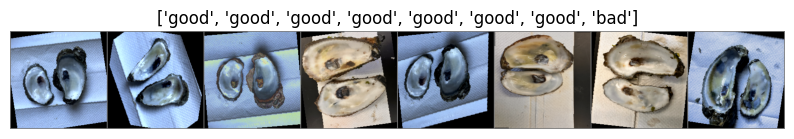

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Function to unnormalize and display an image
def imshow(img, title):
    img = img / 2 + 0.5     # unnormalize from [-1,1] to [0,1]
    npimg = img.numpy()
    plt.figure(figsize=(10, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show a grid of 8 images
classes = train_data.classes  # ['bad', 'good']
imshow(torchvision.utils.make_grid(images[:8]), title=[classes[label] for label in labels[:8]])


In [16]:
from collections import Counter
import os

def count_images(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

# Paths
train_counts = count_images('train')
test_counts = count_images('test')

# Print results
print("Training Set Counts:")
for label, count in train_counts.items():
    print(f"  {label}: {count} images")

print("\nTesting Set Counts:")
for label, count in test_counts.items():
    print(f"  {label}: {count} images")


Training Set Counts:
  bad: 53 images
  good: 97 images

Testing Set Counts:
  bad: 38 images
  good: 37 images


In [18]:
import torch.optim as optim

# Handle class imbalance
pos_weight = torch.tensor([97 / 53]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Only train classifier layer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


In [20]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")


Epoch 1/10, Loss: 9.4099, Accuracy: 61.33%
Epoch 2/10, Loss: 8.0694, Accuracy: 68.00%
Epoch 3/10, Loss: 6.7454, Accuracy: 65.33%
Epoch 4/10, Loss: 6.1682, Accuracy: 72.67%
Epoch 5/10, Loss: 5.8841, Accuracy: 74.67%
Epoch 6/10, Loss: 5.1130, Accuracy: 80.67%
Epoch 7/10, Loss: 4.8371, Accuracy: 88.00%
Epoch 8/10, Loss: 4.4393, Accuracy: 82.67%
Epoch 9/10, Loss: 3.9822, Accuracy: 88.67%
Epoch 10/10, Loss: 4.0701, Accuracy: 90.00%


In [22]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total * 100
print(f"🧪 Test Accuracy: {test_acc:.2f}%")


🧪 Test Accuracy: 78.67%


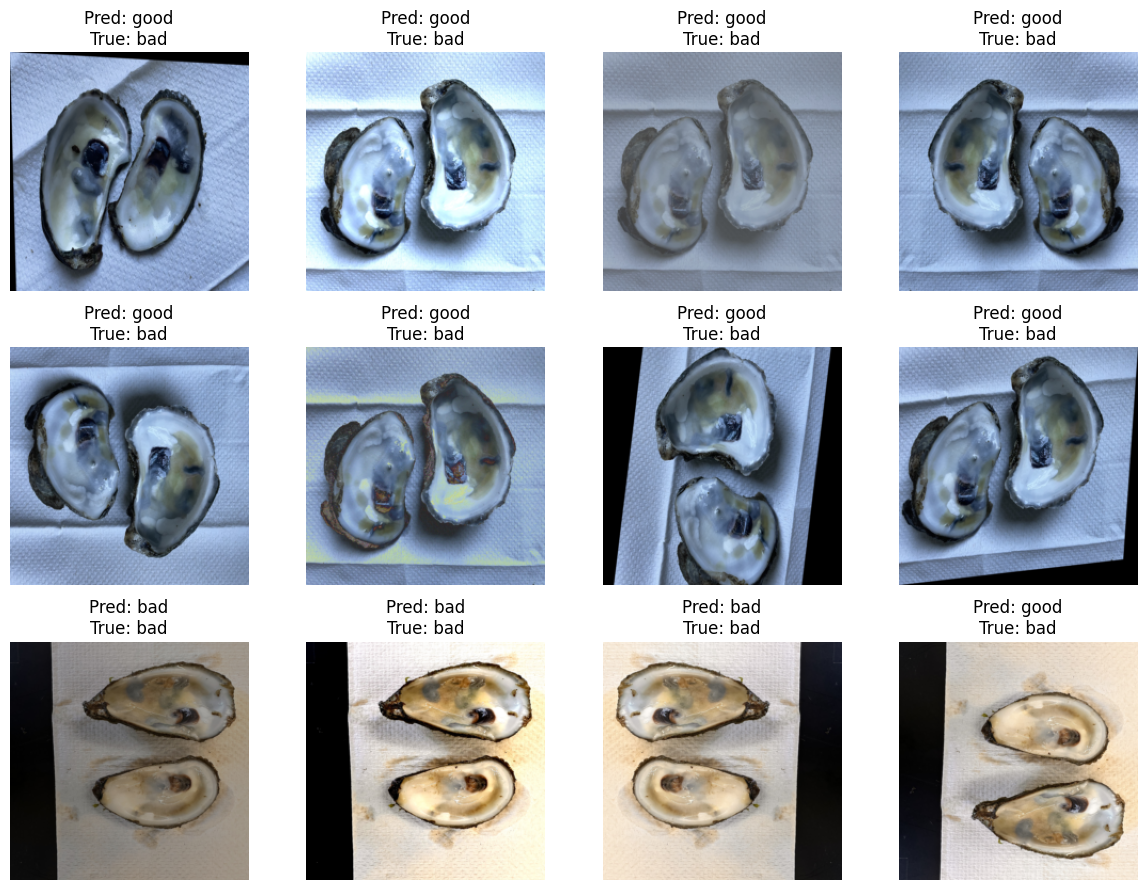

In [26]:
import matplotlib.pyplot as plt

# Get class names
class_names = test_data.classes  # ['bad', 'good']

# Show a few test predictions
model.eval()
fig, axs = plt.subplots(3, 4, figsize=(12, 9))  # 12 images

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu().squeeze().long()
        images = images.cpu()
        
        for idx in range(min(len(images), 12)):
            row = idx // 4
            col = idx % 4
            img = images[idx] / 2 + 0.5  # unnormalize
            npimg = img.numpy().transpose((1, 2, 0))
            axs[row, col].imshow(npimg)
            axs[row, col].set_title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx].item()]}")
            axs[row, col].axis('off')
        break  # only show one batch

plt.tight_layout()
plt.show()


In [28]:
!pip install scikit-learn


  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl (22.4 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


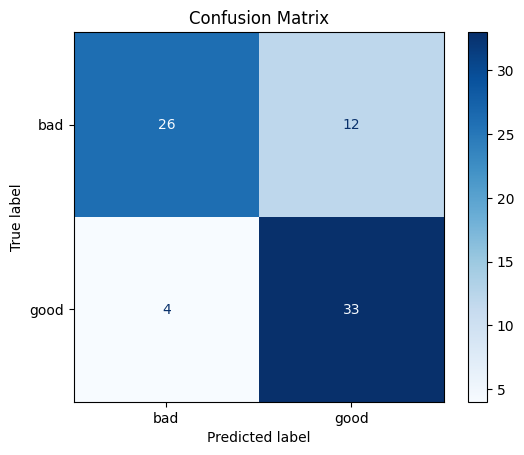

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Gather all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Convert to binary
all_preds = np.array(all_preds).astype(int).flatten()
all_labels = np.array(all_labels).astype(int).flatten()

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


The confusion matrix shows that the model performs well overall, correctly identifying 33 out of 37 “good” oysters and 26 out of 38 “bad” oysters. This results in an overall test accuracy of approximately 78.7%. The model demonstrates strong **recall** for the “good” class (about 89%), meaning it successfully detects most oysters that are actually good. However, its **precision** is slightly lower at around 73%, indicating that a noticeable portion of oysters predicted as “good” are actually “bad.” In other words, the model occasionally misclassifies unhealthy oysters as healthy, which could be a concern depending on the application. These misclassifications (12 false positives and 4 false negatives) suggest the model may benefit from further tuning, additional data (especially for the “bad” class), or techniques to handle class imbalance. Nonetheless, the model is off to a strong start and is able to distinguish between the two classes with reasonable reliability.


In [35]:
import matplotlib.pyplot as plt

wrong_images = []
wrong_preds = []
wrong_labels = []

correct_images = []
correct_preds = []
correct_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        preds = torch.round(torch.sigmoid(outputs)).cpu()
        images = images.cpu()
        labels = labels.cpu()

        for i in range(len(images)):
            if preds[i] != labels[i]:
                wrong_images.append(images[i])
                wrong_preds.append(int(preds[i].item()))
                wrong_labels.append(int(labels[i].item()))
            else:
                correct_images.append(images[i])
                correct_preds.append(int(preds[i].item()))
                correct_labels.append(int(labels[i].item()))


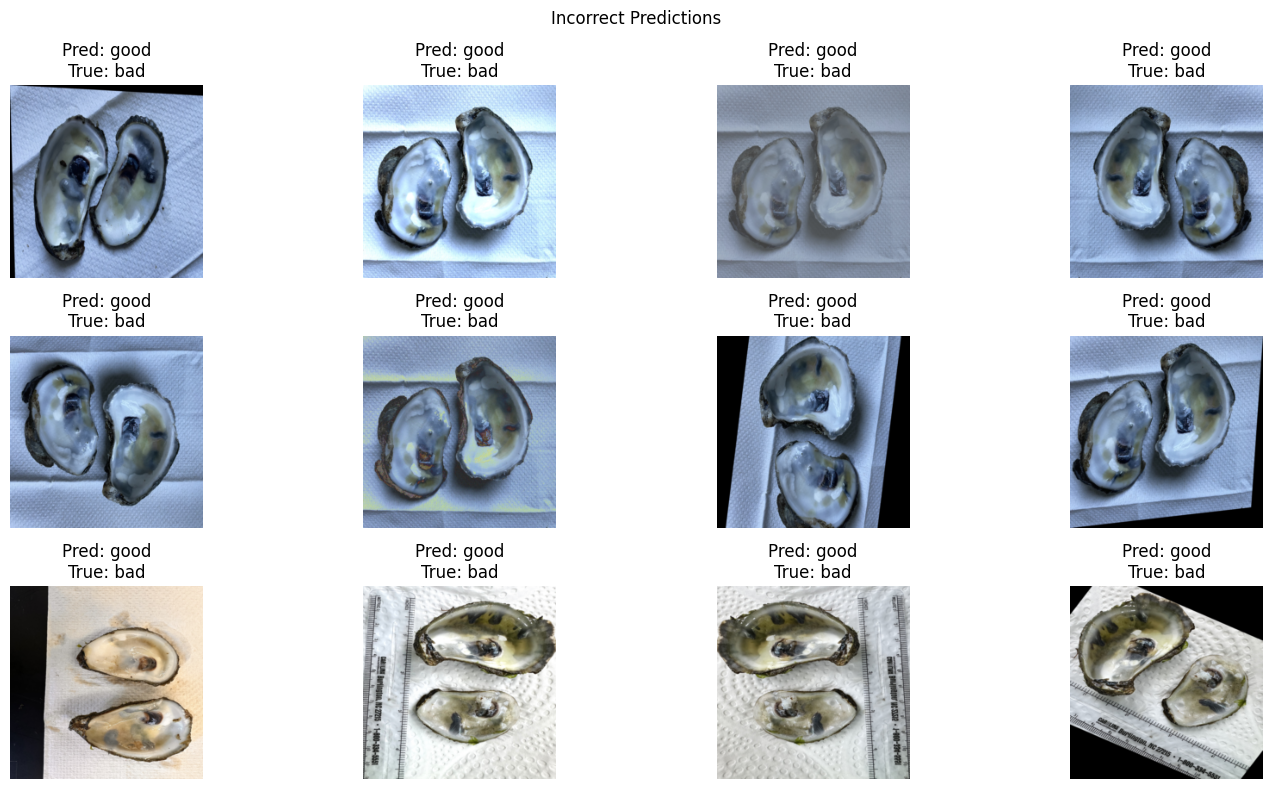

In [37]:
def show_predictions(images, preds, labels, title, class_names, max_display=12):
    plt.figure(figsize=(15, 8))
    for i in range(min(len(images), max_display)):
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy().transpose((1, 2, 0))
        plt.subplot(3, 4, i+1)
        plt.imshow(npimg)
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Class names
class_names = test_data.classes

# Show wrong predictions
show_predictions(wrong_images, wrong_preds, wrong_labels, "Incorrect Predictions", class_names)


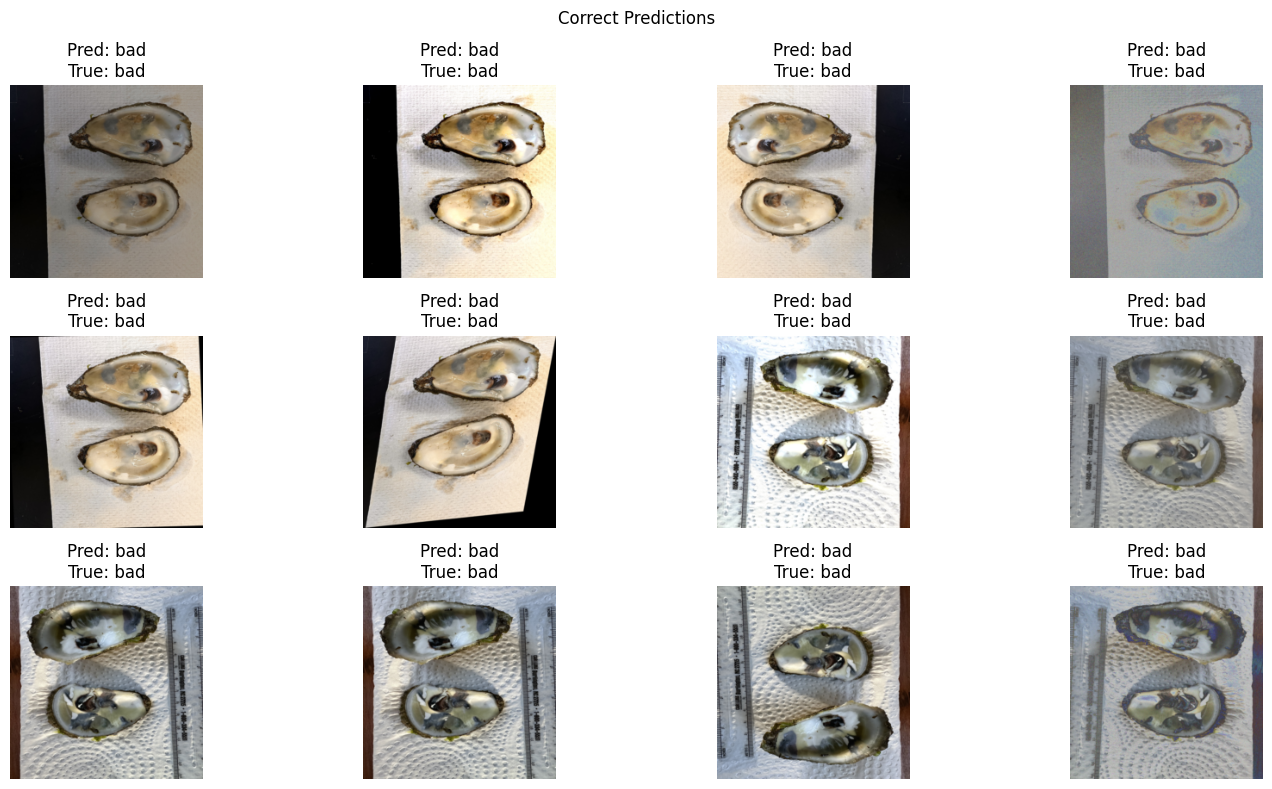

In [39]:
# Show correct predictions
show_predictions(correct_images, correct_preds, correct_labels, "Correct Predictions", class_names)


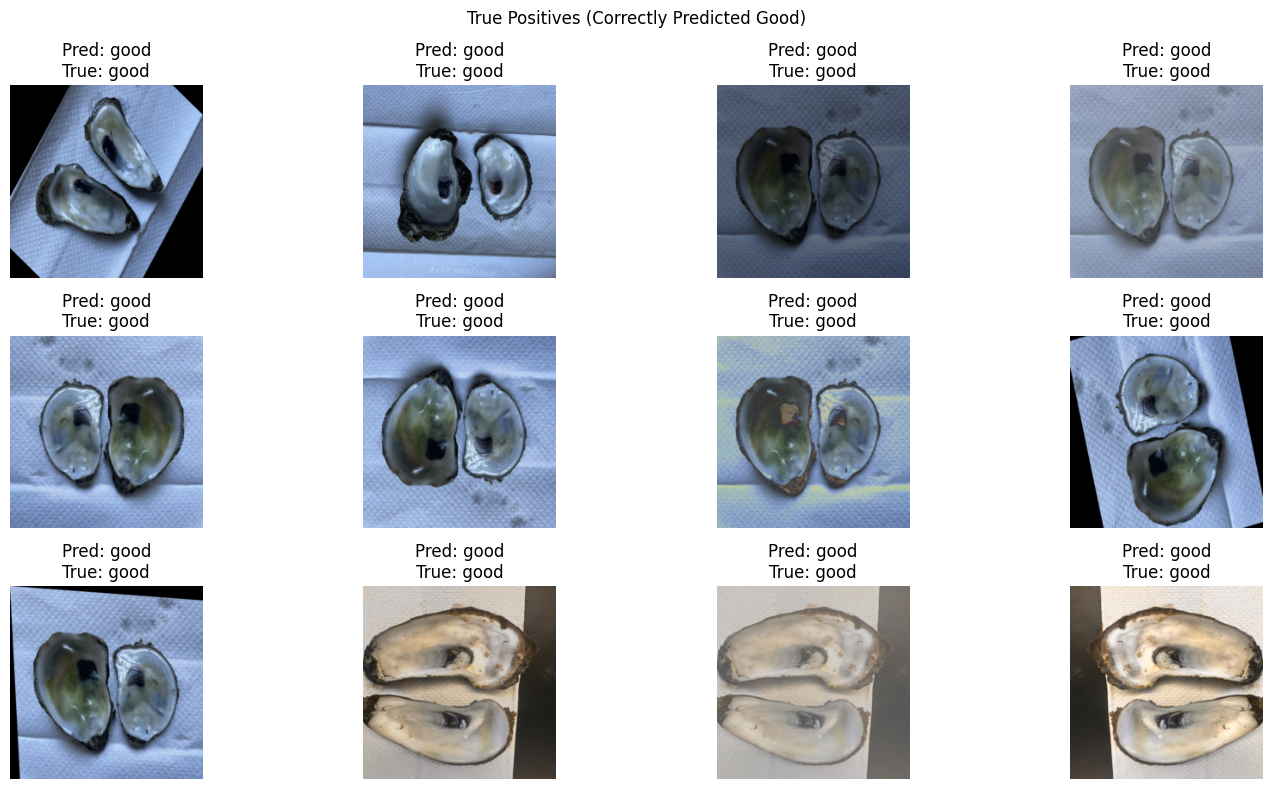

In [41]:
# Show only true positives: predicted = good (1) and label = good (1)
true_positive_images = []
true_positive_preds = []
true_positive_labels = []

for i in range(len(correct_images)):
    if correct_preds[i] == 1 and correct_labels[i] == 1:
        true_positive_images.append(correct_images[i])
        true_positive_preds.append(correct_preds[i])
        true_positive_labels.append(correct_labels[i])

# Visualize true positives
show_predictions(true_positive_images, true_positive_preds, true_positive_labels,
                 "True Positives (Correctly Predicted Good)", class_names)


In [43]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

         bad       0.87      0.68      0.76        38
        good       0.73      0.89      0.80        37

    accuracy                           0.79        75
   macro avg       0.80      0.79      0.78        75
weighted avg       0.80      0.79      0.78        75

